In [35]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode
from sklearn import preprocessing

from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

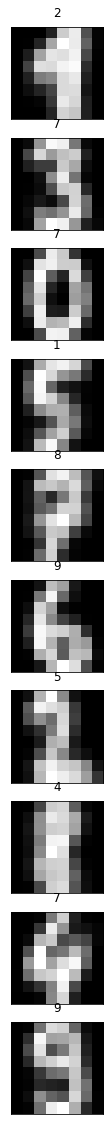

In [15]:
from sklearn.datasets import load_digits

#1.
X = load_digits().data

kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

centers = kmeans.cluster_centers_.reshape(10,8,8)

fig, ax = plt.subplots(10, figsize = (20, 20))
for i in range(len(centers)):
    ax[i].matshow(centers[i])
    ax[i].set_title(kmeans.labels_[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()


In [26]:
#2.
#Well for starters, we are way off on those labels. Lets adjust that.

labels = np.zeros_like(y_kmeans)
for i in range(10):
    true = (y_kmeans == i)
    labels[true] = mode(load_digits().target[true])[0]

#3.
print(accuracy_score(load_digits().target, labels))
print(confusion_matrix(load_digits().target, labels))

#See interpretation below.

#4.
fowlkes_mallows_score(load_digits().target, labels)


0.7935447968836951
[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   0 154   0   2   0   7   7  13]
 [  0   5   0   0 164   0   0   9   3   0]
 [  0   0   0   1   2 136   1   0   0  42]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   2   0   0   0   0   0 175   2   0]
 [  0   6   3   2   0   4   2   5 101  51]
 [  0  20   0   6   0   6   0   7   2 139]]


0.702011167963721

## Evaluation

To begin, the accuracy score and confusion matrix return a fairly strong evaluation. The model can accurately predict 79% of the values. Looking at the confusion matrix, it appear that our clustering methos is a bit too eager to predict something as a '9' or '0'. It has a particularily noticeable problem deciphering between '1' and '9'.

I also believe this to be the reason for the slightly lower fowlkes-Mallow Score. As this score takes into account the similarities between clusters, it is likely weighted by the fact that '1' and '9' are incredibly similar and therefore not appropriately classified.

### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

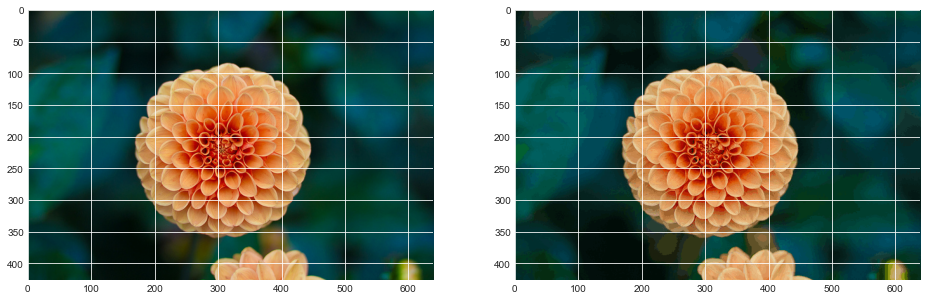

In [260]:
from sklearn.datasets import load_sample_image
flower = load_sample_image('flower.jpg')

savetheflower = flower

data = flower / 255.0
data = data.reshape(427 * 640, 3)

kmeans = MiniBatchKMeans(100)
kmeans.fit(data)
new_colours = kmeans.cluster_centers_[kmeans.predict(data)]
flower_recolored = new_colours.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(flower)
ax[1].imshow(flower_recolored)
plt.show()

## Justification

In the case, I realized that any amount of clustering would drastically reduce the image size (unless of course we are producing millions of clusters). For this reason, I thought it was appropriate to perform several trials until the level of detail in the new image was close to the original.

In this chosen clustering, we can see that the background shading is far from perfect. Nonetheless, we have a farily clear image.

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [200]:
df = pd.read_csv(r'C:\Users\David\Documents\code\Mod_4\4-3-clustering\data\college.csv')
df.Private = np.where(df.Private == 'Yes', 0, 1)
X = df.drop(['Private', 'Unnamed: 0'], axis=1)

In [205]:
#1.
kmeans = KMeans(n_clusters=2)
X = preprocessing.normalize(X)

kmeans.fit(X)
y_kmeans = kmeans.predict(X)

print(accuracy_score(df.Private, kmeans.labels_))
print(confusion_matrix(df.Private, kmeans.labels_))
fowlkes_mallows_score(df.Private, kmeans.labels_)


0.9047619047619048
[[548  17]
 [ 57 155]]


0.8635220144275176

## Evaluation

The model works, although it can be quite shaky. If you run the code several times, you can see that the clusters are often the opposite labels. This is reflected by a low accuracy score, and an absolutely horrible confusion matrix. As the Fowlkes_Mallows score seems to not take these labels into account, it accurately and consistently keeps a fairly high score.

0.9047619047619048
[[548  17]
 [ 57 155]]
0.8635220144275176


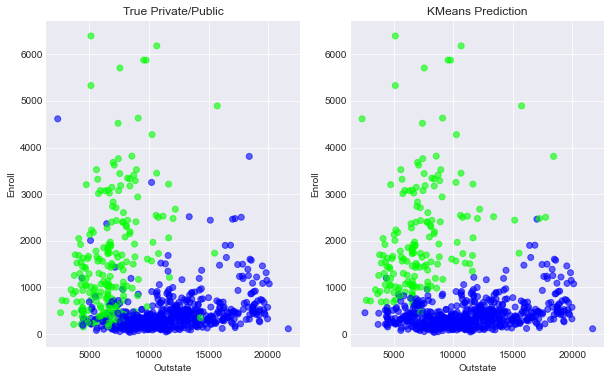

In [231]:
#2.
from sklearn.cluster import SpectralClustering

kmeans = KMeans(n_clusters=2, n_init=20, random_state=1)
X = preprocessing.normalize(X)

kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

print(accuracy_score(df.Private, kmeans.labels_))
print(confusion_matrix(df.Private, kmeans.labels_))
print(fowlkes_mallows_score(df.Private, kmeans.labels_))


fig, ax = plt.subplots(1,2, figsize=(10, 6))
ax[0].scatter(df.Outstate, df.Enroll, c=df.Private, cmap='brg', alpha=0.6)
ax[0].title.set_text('True Private/Public')
ax[0].set_xlabel('Outstate')
ax[0].set_ylabel('Enroll')
ax[1].scatter(df.Outstate, df.Enroll, c=y_kmeans, cmap='brg', alpha=0.6)
ax[1].set_xlabel('Outstate')
ax[1].set_ylabel('Enroll')
ax[1].title.set_text('KMeans Prediction')

plt.style.use('seaborn-darkgrid')

## Justification:

I didn't need to try too hard to make this much more accurate. While I did increase the amount of iterations (which helped only slightly), the real problem with this model was that it had no idea which label to assign to the clusters. By simply changing the initial random state, it now consistently chooses the correct labels for the clusters.

A quick look at the side-by-side plot (true dataset labels against k-means predictions), we can se that the algorithm is near perfect in that it only mislabels outlier school which fall deep into the opposite cluster.

The x,y parameters for the visualization were chosen as they have the highest correlation scores among the dataset.
